## Model Training - Fine-tune the model with our data (Sentences and catchphrases)

In [2]:
# Global Variables
DRIVE_HOME = '/content/drive'
CODE_HOME = '/MyDrive/LawDigestAI'

# Drive Mount
from google.colab import drive
drive.mount(DRIVE_HOME)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Initialization and Train Test Split

In [3]:
import pandas as pd
import ast

input_file_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/preprocessed_summ_data.csv"
summ_data = pd.read_csv(input_file_path)
summ_data_samp = summ_data.copy()

PROMPT = "Generate an abstract list of important phrases that summarize the case document: "

# Prepare dataset for training
summ_data_samp['input'] = PROMPT + summ_data_samp['selected_sentences']

# Convert stringified lists to actual lists
summ_data_samp['catchphrases'] = summ_data_samp['catchphrases'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Join the list into a single string
summ_data_samp['output'] = summ_data_samp['catchphrases'].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else "")

# Split data into 95% train and 5% test
train_data = summ_data_samp.sample(frac=0.95, random_state=42)  # 95% for training
test_data = summ_data_samp.drop(train_data.index)               # Remaining 5% for testing

# Save to CSV
train_data_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/training_data.csv"
test_data_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/test_data.csv"
train_data[['input', 'output']].to_csv(train_data_path, index=False, header=False)
test_data[['input', 'output']].to_csv(test_data_path, index=False, header=False)

print(f"Training data saved to {train_data_path}")
print(f"Test data saved to {test_data_path}")


Training data saved to /content/drive/MyDrive/LawDigestAI/2_Generation/catchphrase_Extraction/training_data.csv
Test data saved to /content/drive/MyDrive/LawDigestAI/2_Generation/catchphrase_Extraction/test_data.csv


In [4]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Tokenize the input with a token limit

In [5]:
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration

MODEL_NAME = "t5-small"

# Load dataset
train_data_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/training_data.csv"
dataset = load_dataset('csv', data_files=train_data_path, split='train', column_names=['input', 'output'])

# Split into training and evaluation sets
split = dataset.train_test_split(test_size=0.1)  # 10% for evaluation
train_dataset = split['train']
eval_dataset = split['test']

# Load T5 tokenizer and model
model_name = MODEL_NAME
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenize the dataset
def preprocess_data(examples):
    # Tokenize input
    model_inputs = tokenizer(examples['input'], max_length=512, truncation=True, padding="max_length")

    # Tokenize output
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['output'], max_length=128, truncation=True, padding="max_length")

    # Add labels to inputs
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Apply tokenization
train_dataset = train_dataset.map(preprocess_data, batched=True)
eval_dataset = eval_dataset.map(preprocess_data, batched=True)

# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(['input', 'output'])
eval_dataset = eval_dataset.remove_columns(['input', 'output'])


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/2454 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/273 [00:00<?, ? examples/s]

## Training Arguments
- Epoch: 10
- evaluation_strategy: "epoch"
- predict_with_generate=True (*main parameter for sequence to sequence model*)

In [6]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=500,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=5e-5,
    predict_with_generate=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Train and Save the model

In [7]:
from transformers import Trainer

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)


# Train the model
trainer.train()

# Save the fine-tuned model
model_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/t5-catchphrase-extraction-model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Fine-tuned model saved to {model_path}")


<ipython-input-7-366e6209fe7d>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.521800,1.298290
2,1.377900,1.231295
3,1.309800,1.203401
4,1.306500,1.186596
5,1.282700,1.176020
6,1.253900,1.167453
7,1.245500,1.163146
8,1.244000,1.159280
9,1.207300,1.157317
10,1.241700,1.156608


Fine-tuned model saved to /content/drive/MyDrive/LawDigestAI/2_Generation/catchphrase_Extraction/t5-catchphrase-extraction-model


## Evaluation

### Loss Graph

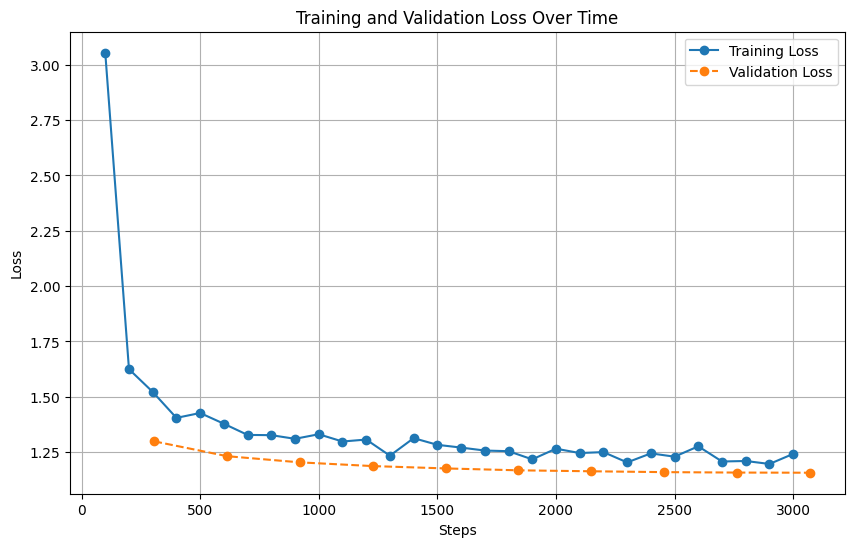

In [8]:
import matplotlib.pyplot as plt

# Extract logs
logs = trainer.state.log_history

# Extract steps, training loss, and validation loss
steps = [log['step'] for log in logs if 'loss' in log]  # Training steps
train_losses = [log['loss'] for log in logs if 'loss' in log]  # Training loss
val_steps = [log['step'] for log in logs if 'eval_loss' in log]  # Validation steps
val_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]  # Validation loss

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label="Training Loss", marker='o')
plt.plot(val_steps, val_losses, label="Validation Loss", marker='o', linestyle='--')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()


In [9]:
!pip install rouge_score
!pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=f265ed6937f734d872b3cb1b04ecb0701276345c6d6be5674ffafae18480dd62
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00


## Rouge Metrics for Test Data

In [10]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import evaluate
import pandas as pd

# Load the fine-tuned model and tokenizer
model_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/t5-catchphrase-extraction-model"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Load the test dataset
test_data_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/test_data.csv"
test_data = pd.read_csv(test_data_path, names=['input', 'output'])

# Generate predictions
predictions = []
references = []
for _, row in test_data.iterrows():
    input_text = row['input']
    reference = row['output']


    # Tokenize input
    input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).input_ids


    # Generate prediction
    outputs = model.generate(
        input_ids,
        max_length=128,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=0.7
    )
    pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    predictions.append(pred_text)
    references.append(reference)


# Calculate ROUGE score using the `evaluate` library
rouge = evaluate.load("rouge")
results = rouge.compute(predictions=predictions, references=references)
print("ROUGE Scores:", results)

# Save predictions and references to a file
results_df = pd.DataFrame({"Input": test_data['input'], "Reference": references, "Prediction": predictions})

test_result_data_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/test_results.csv"
results_df.to_csv(test_result_data_path, index=False)
print(f"Evaluation results saved to {test_result_data_path}")


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


ROUGE Scores: {'rouge1': 0.35144637483241736, 'rouge2': 0.15611918324340074, 'rougeL': 0.2707663787797275, 'rougeLsum': 0.27213503465949584}
Evaluation results saved to /content/drive/MyDrive/LawDigestAI/2_Generation/catchphrase_Extraction/test_results.csv


In [11]:
test_result_data_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/test_results.csv"
test_results = pd.read_csv(test_result_data_path)
test_results.head()

,Input,Reference,Prediction
0,Generate an abstract list of important phrases...,"no special or particular principle arising, mi...",application for extension of time to file and ...
1,Generate an abstract list of important phrases...,"social security law, decision to cancel newsta...","appeal from social security appeals tribunal, ..."
2,Generate an abstract list of important phrases...,"legal professional privilege, applicable princ...","advice privilege and litigation privilege, pra..."
3,Generate an abstract list of important phrases...,whether s 347(1) and s 348(1) of the migration...,application for judicial review of a migration...
4,Generate an abstract list of important phrases...,"application for costs, discretion of the court...",appeal from decision of administrative appeals...


## Test Pipeline

In [12]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

def generate_catchphrases(input_text, model_path):
    """
    Generate a summary of important phrases from a given text using a fine-tuned T5 model.

    Args:
        input_text (str): The text to process.
        model_path (str): Path to the fine-tuned T5 model and tokenizer.

    Returns:
        list: List of important phrases summarizing the text.
    """
    # Load the fine-tuned model and tokenizer
    tokenizer = T5Tokenizer.from_pretrained(model_path)
    model = T5ForConditionalGeneration.from_pretrained(model_path)

    # Define the prompt
    PROMPT = "Generate an abstract list of important phrases that summarize the case document: "
    full_input_text = f"{PROMPT}{input_text}"

    # Tokenize the input
    input_ids = tokenizer(full_input_text, return_tensors="pt", truncation=True, max_length=512).input_ids

    # Generate prediction
    outputs = model.generate(
        input_ids,
        max_length=128,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=0.7
    )

    # Decode the output and split into a list of phrases
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    phrases_list = [phrase.strip() for phrase in output_text.split(',')]

    return phrases_list

# Example usage
model_path = f"{DRIVE_HOME}{CODE_HOME}/2_Generation/catchphrase_Extraction/t5-catchphrase-extraction-model"
inp_text = """Generate an abstract list of important phrases that summarize the case document: 3 Thereafter the applicant sought judicial review of the Tribunal's decision from the Federal Magistrates Court, and upon the basis of comprehensive reasons for judgment, Federal Magistrate Smith dismissed the application upon the basis that the Tribunal's decision was not affected by any jurisdictional error, and was thus a ' privative clause decision' within s 474(1) of the Migration Act 1958 (Cth). 5 The outcome was that the Court was left with no viable basis having been articulated as to why the reasons for decision of the Federal Magistrates Court were otherwise than soundly conceived. In the course of those reasons extending over 47 paragraphs, his Honour undertook a thorough review of the background to the application and of the consequential findings which he thereupon made, and also of the legal consequences of those findings. I certify that the preceding five (5) numbered paragraphs are a true copy of the Reasons for Judgment herein of the Honourable Justice Conti J. 1 The present application filed on 1 December 2005 is for an extension of time in which to file and serve a notice of appeal from the judgment of Smith FM delivered on 8 November 2005, whereby his Honour found that the decision of the Refugee Review Tribunal handed down on 17 June 2005 adversely to the present applicant was not affected by jurisdictional error. In the present proceedings, the applicant was not legally represented. 4 The applicant filed a supporting affidavit in this Court, presumably handwritten by another person on her behalf, which sought to explain the reasons for her delay in making the present application, and in which she detailed her practice of the Falun Gong religion in China. Her visa application was refused by the Minister's delegate on 10 March 2005, and her application to the Refugee Review Tribunal for review of that decision was subsequently refused on 17 June 2005, pursuant to a decision bearing date 16 June 2005. 2 The background to that application is that the applicant had arrived in Australia as a visitor from China in November 2004, and had been taken into detention some weeks after her arrival for what were considered to be breaches of her visa. In those proceedings, the applicant was legally represented."""
predicted_phrases = generate_catchphrases(inp_text, model_path)
print(f"Predicted Output as List: {predicted_phrases}")


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Predicted Output as List: ['application for extension of time to file and serve notice of appeal from decision of federal magistrates court', 'whether decision affected by jurisdictional error', 'migration']
